In [23]:
import bisect
from itertools import product
from functools import reduce

from bitstring import BitStream, BitArray
import matplotlib.pyplot as plt
from hmmlearn import hmm
import numpy as np
from sklearn import manifold
import genomics_compression_helpers as helpers

%matplotlib inline

In [3]:
def naive_compression(genome):
    
    d = {
        "A":BitArray("0b00"),
        "G":BitArray("0b01"),
        "C":BitArray("0b10"),
        "T":BitArray("0b11")
    }
    
    bits = BitArray(2*len(genome))
    for pos, character in enumerate(genome):
        bits[2*pos:2*pos+2] = d[character]
    
    return bits

class Tree():
    
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def __str__(self):
        return f"({str(self.left)}, {str(self.right)})"

def message_tree(message_probs_dictionary):
    
    messages_as_list = list(message_probs_dictionary.items())
    messages_as_list.sort(key=lambda x: x[1])
    messages = [x[0] for x in messages_as_list]
    message_probs = [x[1] for x in messages_as_list]
    
    return message_tree_internal(messages, message_probs)


def message_tree_internal(messages, message_probs):
    
    while(len(messages) > 1):
        
        leaves = Tree(messages[0], messages[1])
        leaf_prob = message_probs[0] + message_probs[1]
        new_index = bisect.bisect_right(message_probs[2:], leaf_prob)
        messages = messages[2:]
        messages.insert(new_index, leaves)
        message_probs = message_probs[2:]
        message_probs.insert(new_index, leaf_prob)
        
    return messages[0]
    
# python is terrible at doing high-depth recursion but this function 
# should only go to a depth of log(n) and therefore should be ok.
def tree_to_encoding(message_tree):
    coding_dict = {}
    
    if isinstance(message_tree, Tree):
        for k, v in tree_to_encoding(message_tree.left).items():
            v.insert("0b0", 0)
            coding_dict[k] = v
        
        for k, v in tree_to_encoding(message_tree.right).items():
            v.insert("0b1", 0)
            coding_dict[k] = v
    
        return coding_dict
    
    else:
        return {message_tree: BitArray()}
    

def compute_huffman_code(message_probs):
    """
    The input is a dictionary of messages, and their relative probabilities (which must add to 1). 
    The output is a dictionary of each message and it's new codeword (a bytestring) in the Huffman encoding. 
    """
    
    return tree_to_encoding(message_tree(message_probs))


def expected_compression(message_probs, message_encoding):
    """
    It is implicit that the messages are strings from the alphabet {A, C, G, T} so each symbol occupies 2 bits. 
    """
    
    expected_original_size = 2 * sum([len(m[0]) * m[1] for m in message_probs.items()])
    
    expected_compressed_size = sum([len(message_encoding[k]) * message_probs[k] for k in message_encoding.keys()])
    
    return expected_compressed_size/expected_original_size

In [4]:
with open("/home/will/Desktop/projects/genomics-1/data/sar-cov-2/txtfiles/LC528232.txt") as fh:
    genome = ""
    for l in fh:
        genome += l[:-1]
    
    genome = genome[1:]

In [6]:
alphabet = "AGCT"

N = 3
countn = {reduce(lambda s, t: s+t, x) : 0 for x in product(alphabet, repeat=N)}

In [7]:
i = 0
buffer = ""
for x in genome:
    i += 1
    buffer += x
    
    if i <= N:
        continue
        
    else:
        buffer = buffer[1:]
        if buffer in countn:
            countn[buffer] +=1
        else:
            countn[buffer] = 1

l = len(genome)
for x in countn:
    countn[x]/= N*l

In [8]:
countn

{'AAA': 0.010077700857273447,
 'AAG': 0.006454633624293502,
 'AAC': 0.006855957994715896,
 'AAT': 0.00852814287147587,
 'AGA': 0.006744479002931897,
 'AGG': 0.0036565109305151445,
 'AGC': 0.003355517652698349,
 'AGT': 0.005674280681805513,
 'ACA': 0.009018650435325463,
 'ACG': 0.0018282554652575723,
 'ACC': 0.004180462191899936,
 'ACT': 0.007513684046241486,
 'ATA': 0.00523951261384792,
 'ATG': 0.008093374803518277,
 'ATC': 0.0037902857206559425,
 'ATT': 0.008639621863259868,
 'GAA': 0.005975273959622309,
 'GAG': 0.00331092605598475,
 'GAC': 0.0037902857206559425,
 'GAT': 0.0049050756384959255,
 'GGA': 0.0031437075683087524,
 'GGG': 0.0014938184899055773,
 'GGC': 0.0024859815167831622,
 'GGT': 0.005049998327815123,
 'GCA': 0.004147018494364737,
 'GCG': 0.000981015127699185,
 'GCC': 0.0020846571463607683,
 'GCT': 0.005819203371124712,
 'GTA': 0.005228364714669521,
 'GTG': 0.0061647882456551065,
 'GTC': 0.0029987848789895543,
 'GTT': 0.007792381525701482,
 'CAA': 0.00783697312241508,
 'C

In [9]:
code = compute_huffman_code(countn)

In [10]:
expected_compression(countn, code)
# this is a bit rubbish

0.9715644301737018

<BarContainer object of 64 artists>

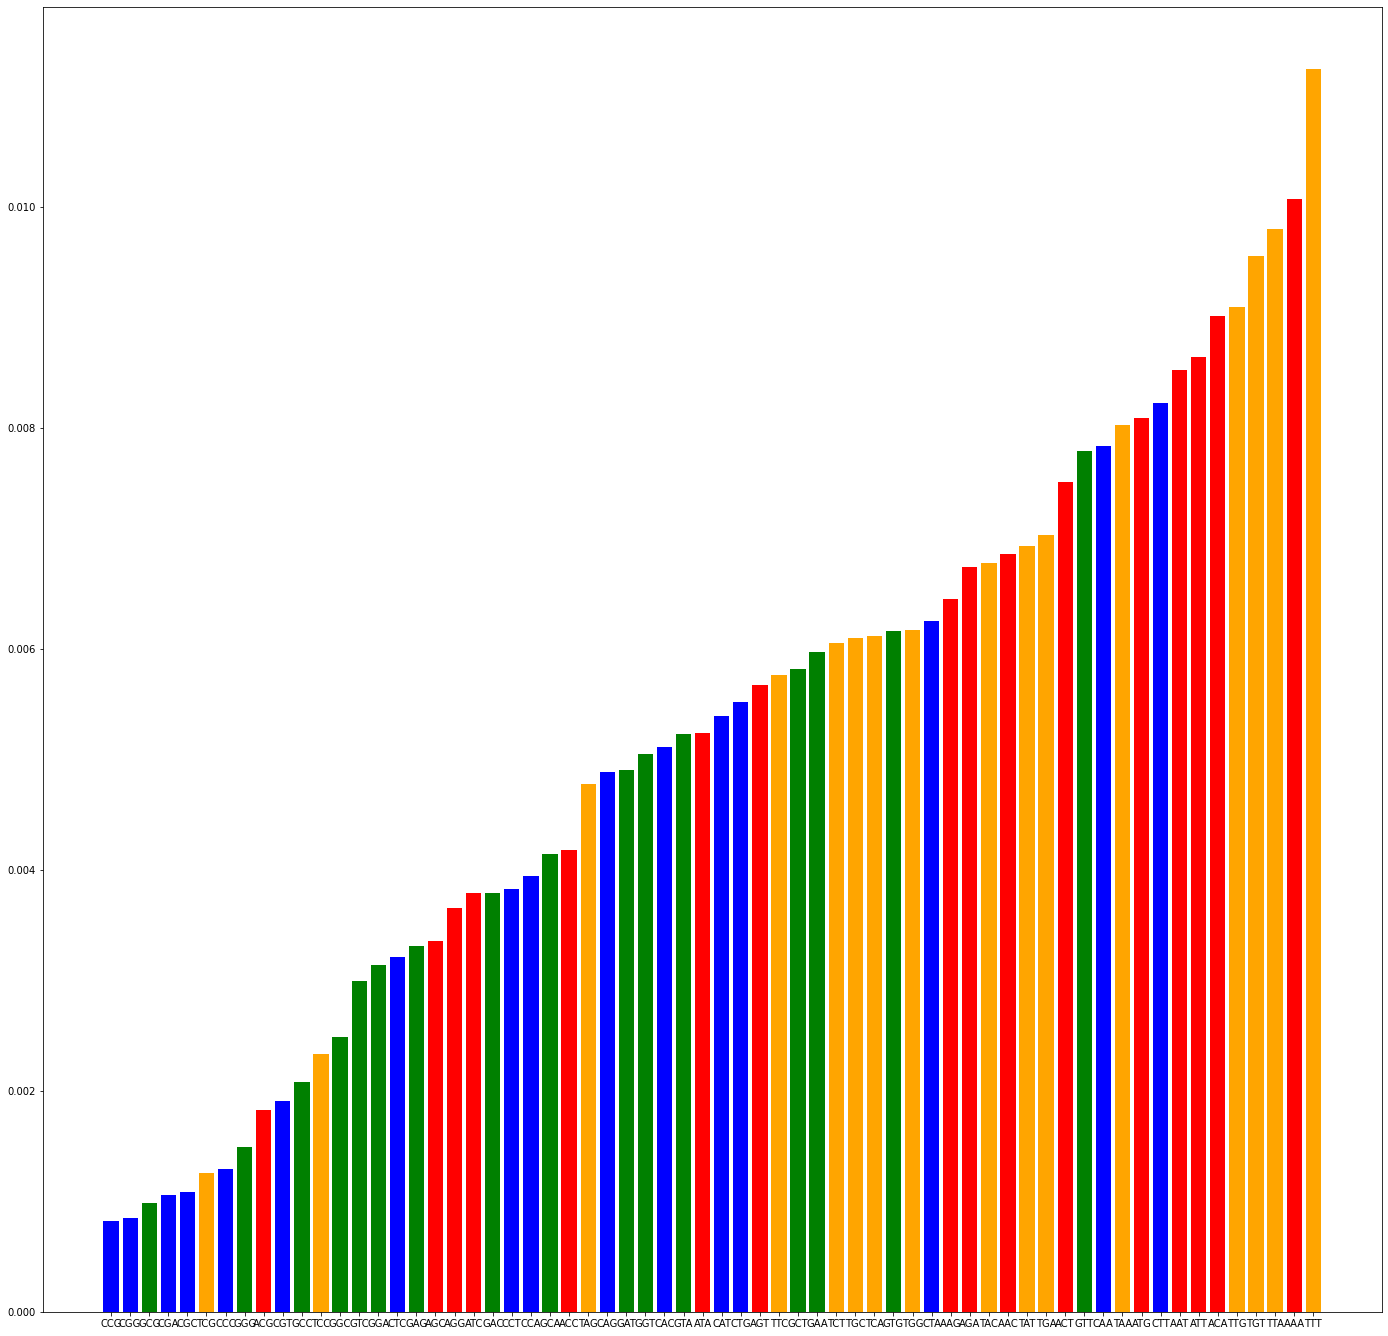

In [11]:
plt.figure(figsize=(24, 24))
messages_as_list = list(countn.items())
messages_as_list.sort(key=lambda x: x[1])
messages = [x[0] for x in messages_as_list]
message_probs = [x[1] for x in messages_as_list]
def cfn(string):
    if string[0] == "A":
        return "r"
    if string[0] == "C":
        return "b"
    if string[0] == "G":
        return "g"
    if string[0] == "T":
        return "orange"
colour_list = [cfn(x[0]) for x in messages_as_list]
plt.bar(messages, message_probs, color=colour_list)

In [576]:
Cs = {k[1:]:v for k,v in countn.items() if k[0] == "C"}

In [10]:
c = compute_huffman_code(Cs)

In [11]:
expected_compression(Cs, c)

0.9305353241077934

In [12]:
messages_as_list[-10:]

[('ATG', 0.008093374803518277),
 ('CTT', 0.008227149593659075),
 ('AAT', 0.00852814287147587),
 ('ATT', 0.008639621863259868),
 ('ACA', 0.009018650435325463),
 ('TTG', 0.009096685729574262),
 ('TGT', 0.009553749595888655),
 ('TTA', 0.009799003377813451),
 ('AAA', 0.010077700857273447),
 ('TTT', 0.01124823027100543)]

In [13]:
sum([f*np.log2(f) for f in countn.values()])

-2.4616766760021025

In [12]:
len(genome)

29901

In [13]:
2 ** 16

65536

In [14]:
"".join(["1" if x == "A" or x == "T" else "0" for x in genome[2::3]])

'011111100110011001111101001101010100110010111111101110001001000001010000000001101101001011101100111101111010111101111001010111110100111110000111111011011110111110010000010111111101110111000010101110110110101011110110110000101001110111011100101111111010110001001110111000100111111000101011011111000010000101111111010011000111111001010011011110011111011110110100111101101110110011111110110010011010001101110100111011001000100111100011000111011000000110110111110000110110011010111110011011010000101000110110011100101000001100110011010010111111111111111111101111111101110010000001110110111101111110001111010101100011011101100110100100011001100011001101011110010111010110101110111001100111111011000111100101011100111111011101111111011110100111111000001110011100011111011011111111101001011100011101110101101010110101100110011101100111111101010011101111110011101110001011001100010110111111110111001001111011010110000011010110111110110111011111011111111000101110011111001101011101101011100101111100100111111

In [17]:
genomepk = np.array([1 if x == "T" or x == "A" else 0 for x in genome])
#genomepk = np.array([1 if (x % 3) == 0 else 0 for x in range(len(genome))])
print(len(genomepk), len(genome))

29901 29901


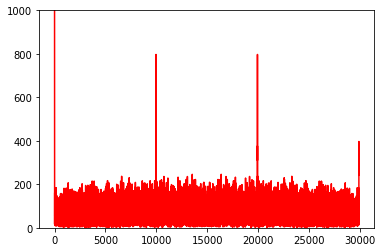

In [18]:
plt.ylim(0, 1000)
#plt.xlim(0, 30000)
plt.plot(np.abs(np.fft.fft(genomepk)), color="r")

In [19]:
np.mean(genomepk)

0.6201799270927394

In [13]:
styphi = """tctttctcaacccacatggcggtcggcaggatcagatcagcagacagcgcgctcaccgtc
gggtaaggatcggagacaatgataaagttacgcggatcgcgccagcccggcatccgatct
tcattgatgttcggcccggcctgcatattgttattacacattacccagtagacgttcagc
ttgccgtctttcaacgcgcgatcctgcgccaccgcatgtaaacccacttttgccgggata
gtgccagcggggatctgccagtgtttttcgcagatatcacggtgtttttcgttcgtcacg
accatgtctgcgggcagacggtgtgagaaggttcccacttcacgcgccgtaccgcaggcg
gaaggctggccggtcagcgagaaaggaccgcagccaggctgggagatttttccggtcagc
agatggaggttgtaaaccaggttattcgcccacacgccgcgggtatgctggttaaaaccc
atcgtccagtaagagatcacgcgcttattcggatcggcgtagagctgtgccaactgttcc
agttgatctttcggcacgccggtcatttcagcagtcttgtccaacgtatattccgccacg
aaggctttatactcgtcgaagctcatcggctcggaagcgtcggagcccggattcttcgcc
gctttttccagcgggtgcgtcgggcgtaagccgtagccgatatccgtcgcccctttacgc
agattcacatgctttgtgaagaaatcctgatttaccgcgttgttctgaataatgtaattc
gcgatatagttaaggatcaccagatcgctttgcggggtaaagacaataccgttgtccgcc
agctcaaagctacggtgctggaaggtggagaggacagcaactttcacattcgggtcggac
aaacggcggttagtgatgcgcgaccataaaatcgggtgcatctccgccatgttggacccc
cacagcacaaacgcatcggcctgctcaatatcgtcgtagcagcccatcggttcatccatg
ccaaaggtgcgcataaagcccaccaccgccgaggccatgcagtgacgcgcgttcgggtcg
atgttgttagagcggaaaccagccttgaacagtttcgcggcggcatagccttcccagatg
gtccattgacccgatccaaacatgccgatcgcttctggtcctttctctttcagggcggtt
ttaaacttctcttccatcacatcgaaggcctgttcccagctcaccggcgtaaactcgccg
tctttgtgatagctgccgtctttcatgcgcagcatcggctgcgtcagacgatctttaccg
tacatgattttgggcaggaagtagcctttaatgcagttcagaccacggttgaccggcgcg
tcggggtcgccctggcaggcgaccacacggccctgctgcgttcccaccaacacaccgcaa
cccgttccgcaaaaacggcacggcgctttatcccatttgatagcttcctgctgcccgaca
acggcgcgggcgacgcccggcacgctcagaccggcagccgccgcagcggccgcaacggcg
ttagctttcataaagctacgacgactgagtttcatggtgtttcctcaccttgctcatcct
gctggtgataaaccagcgacaccgccagcacgccctcgacattgcgtactgactcaattg
tttgcatcagcgtttcactctggtctgcttccgccaccacgatcagttgcccgctttcaa
cgtcgcttaacgcgacttcgcaacccggcaacgtgttcaactgtgtgccaatggcggcga
tgttctgacttttggcctgcacgaccaggctacagacctgccagttagtgcgcatggtgg
ttctccgctttgatggctgacacgggacagatagccacacacgccccgcatccgttacag
gcctgcgagtcaagctgcggctggtaaataccggataacgtgggacgaaaggtaatggcc
ataggttcacaactgtccaggcaacgatggcattcaaccgactgcctggcgaggcagttt
tccgtgagtgtaaaaatcagatcccaggccctggtgcggcgcggaagaaagagagattcg
ggacaggcctgcgcacaggcataacaaaagctgcactcgccccgtttgaaatttacgctc
ggatatccccccatccctcgctgcaggatgtcggcctcacacgcctggatgcaggcgtcg
caacgcagacaatgtgcgagaaaataggtcgtttctctggcccacggcggaagaatccca
ttgctggcgttgcgccaactgccggtcaacatgcttcgacgggataaatcaaccatgata
tcgcccttccataacgacacgcttccatagggagtgaatgccaataaaaaccgtacaatt
tatgagtagttatttttgtaaataagatatttcaggatgtgtaagagatgcataccccga
tagaggtaaatgctgttgccggatcaaaagagtgccgggtaaagacccgtaaacgtgctt
tttctcacatttcaatgagttatatagatatttatataacggaaatcactaatagctgat
aatttcatttacattatcaatatcagaatattccactatataaaaagacgttattttatt""".replace("\n", "").upper()

In [15]:
styphipk = np.array([1 if x == "T" or x == "A" else 0 for x in styphi])
#genomepk = np.array([1 if (x % 3) == 0 else 0 for x in range(len(genome))])
print(len(styphipk), len(styphi))

2640 2640


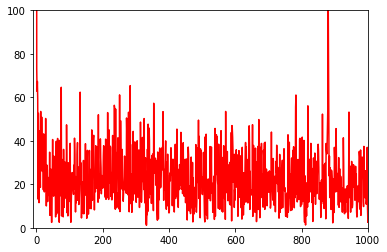

In [22]:
plt.ylim(0, 100)
plt.xlim(-10, 1000)
plt.plot(np.abs(np.fft.fft(styphipk)), color="r")

In [27]:
genome_data = np.array([helpers.cvt_numeric(x) for x in genome]).reshape(-1, 1)
genome_data_triplets = np.array([to_triplets(genome, i) for i in range(0, len(genome), 3)]).reshape(-1, 1)

print(countn)

{'AAA': 0.010077700857273447, 'AAG': 0.006454633624293502, 'AAC': 0.006855957994715896, 'AAT': 0.00852814287147587, 'AGA': 0.006744479002931897, 'AGG': 0.0036565109305151445, 'AGC': 0.003355517652698349, 'AGT': 0.005674280681805513, 'ACA': 0.009018650435325463, 'ACG': 0.0018282554652575723, 'ACC': 0.004180462191899936, 'ACT': 0.007513684046241486, 'ATA': 0.00523951261384792, 'ATG': 0.008093374803518277, 'ATC': 0.0037902857206559425, 'ATT': 0.008639621863259868, 'GAA': 0.005975273959622309, 'GAG': 0.00331092605598475, 'GAC': 0.0037902857206559425, 'GAT': 0.0049050756384959255, 'GGA': 0.0031437075683087524, 'GGG': 0.0014938184899055773, 'GGC': 0.0024859815167831622, 'GGT': 0.005049998327815123, 'GCA': 0.004147018494364737, 'GCG': 0.000981015127699185, 'GCC': 0.0020846571463607683, 'GCT': 0.005819203371124712, 'GTA': 0.005228364714669521, 'GTG': 0.0061647882456551065, 'GTC': 0.0029987848789895543, 'GTT': 0.007792381525701482, 'CAA': 0.00783697312241508, 'CAG': 0.004882779840139126, 'CAC':

In [28]:
model = hmm.MultinomialHMM(2, params="", init_params="", tol=0.005, n_iter=500)
model.startprob_ = np.array([0.5, 0.5])
model.transmat_ = np.array([[0.99, 0.01], [0.2, 0.8]])
model.emissionprob_ = np.array([[0.33, 0.33, 0.17, 0.17], [0.25, 0.25, 0.25, 0.25]])

In [29]:
model.fit(genome_data)

MultinomialHMM(init_params='', n_components=2, n_iter=500, params='',
               random_state=RandomState(MT19937) at 0x7F5E6409B540, tol=0.005)

In [30]:
print("starts", model.startprob_, "\n transitions", model.transmat_, "\n emissions", model.emissionprob_)

starts [0.5 0.5] 
 transitions [[0.99 0.01]
 [0.2  0.8 ]] 
 emissions [[0.33 0.33 0.17 0.17]
 [0.25 0.25 0.25 0.25]]


In [31]:
x = model.decode(genome_data, algorithm="map")

0


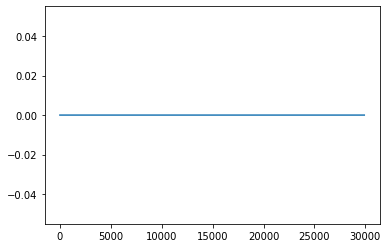

In [32]:
#plt.xlim(1500, 1600)
plt.plot(x[1])
print(sum(x[1]))

In [33]:
#starts [4.17517482e-09 9.99999996e-01] 
# transitions [[0.99 0.01]
# [0.2  0.8 ]] 
# emissions [[0.31285016 0.30931305 0.18812055 0.18971624]
# [0.03992806 0.54328543 0.34575766 0.07102885]]


In [34]:
model2 = hmm.MultinomialHMM(2, params="ste", init_params="", tol=0.005, n_iter=100)
model2.startprob_ = np.array([0.5, 0.5])
model2.transmat_ = np.array([[0.99, 0.01], [0.2, 0.8]])
model2.emissionprob_ = np.array([[1.0/64.0 for i in range(64)], [1.0/64.0 for i in range(64)]])

starts [2.16507292e-35 1.00000000e+00] 
 transitions [[9.99012474e-01 9.87526404e-04]
 [5.17335396e-04 9.99482665e-01]]


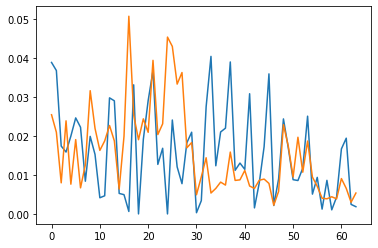

In [35]:
model2.fit(genome_data_triplets)
print("starts", model2.startprob_, "\n transitions", model2.transmat_)
plt.plot(model2.emissionprob_[0,:])
plt.plot(model2.emissionprob_[1,:])

6726
3241
9967


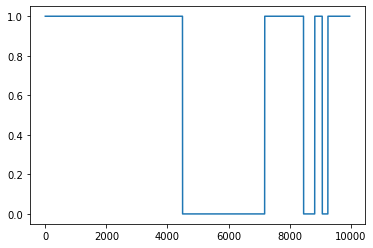

In [36]:
y = model2.decode(genome_data_triplets, algorithm="viterbi")
plt.plot(y[1])
print(sum(y[1]))
print(len(y[1]) - sum(y[1]))
print(len(y[1]))

starts [1.01664703e-168 3.62534650e-057 1.00000000e+000] 
 transitions [[9.98315139e-01 1.49922566e-03 1.85635507e-04]
 [5.69021643e-03 9.86094530e-01 8.21525340e-03]
 [2.42350335e-04 8.61662711e-04 9.98895987e-01]]


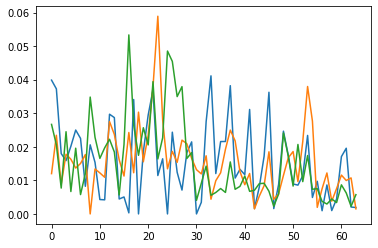

In [37]:
model3 = hmm.MultinomialHMM(3, params="ste", init_params="", tol=0.005, n_iter=250)
model3.startprob_ = np.array([0.33, 0.33, 0.34])
model3.transmat_ = np.array([[0.98, 0.01, 0.01], [0.1, 0.8, 0.1], [0.02, 0.01, 0.97]])
model3.emissionprob_ = np.array([[1.0/64.0 for i in range(64)], [1.0/64.0 for i in range(64)], [1.0/64.0 for i in range(64)]])
model3.fit(genome_data_triplets)
print("starts", model3.startprob_, "\n transitions", model3.transmat_)
plt.plot(model3.emissionprob_[0,:])
plt.plot(model3.emissionprob_[1,:])
plt.plot(model3.emissionprob_[2,:])

12915
-2948
9967


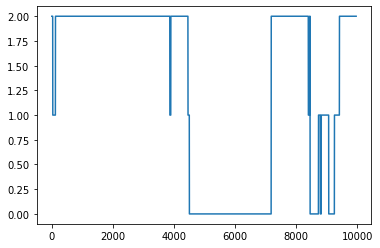

In [528]:
yy = model3.decode(genome_data_triplets, algorithm="viterbi")
plt.plot(yy[1])
print(sum(yy[1]))
print(len(yy[1]) - sum(yy[1]))
print(len(yy[1]))

In [77]:
i =0
model2.decode(genome_data_triplets[4500:4600-i], algorithm="viterbi")

(-387.69087812147626,
 array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

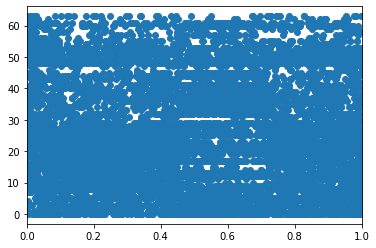

In [33]:
plt.xlim(0, 1)
plt.scatter(np.linspace(0, 1, len(genome_data_triplets)),genome_data_triplets)

In [25]:
def cvt_numeric(x):
    
    d = {
        'A': 0,
        'T': 1, 
        'G': 2,
        'C': 3
    }
    
    return d[x]
    
def to_triplets(g, i):
    return 16*cvt_numeric(g[i]) + 4*cvt_numeric(g[i+1]) + cvt_numeric(g[i+2])

def cvt_symbolic(y):
    
    d = {
        0: 'A',
        1: 'T',
        2: 'G',
        3: 'C'
    }
    
    return d[y]

def from_triplets(n):
    
    c1 = int(n/16)
    c2 = int((n - 16*c1)/4)
    c3 = n % 4
    
    return (c1, c2, c3)

def encode_hmm(model, **kwargs):
    pass

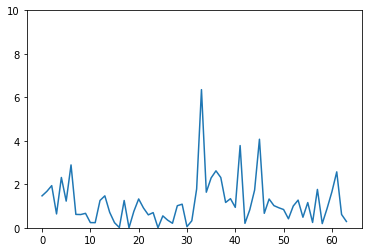

In [130]:
plt.ylim(0, 10)
ratios = model2.emissionprob_[0,:]/(model2.emissionprob_[1,:] + 0.001)
plt.plot(ratios)

In [36]:
print([
    reduce(lambda a, x: a + cvt_symbolic(x), from_triplets(y), "") for y in [i  for i, x in enumerate(ratios) if x > 1.25]
])

['AAA', 'AAT', 'AAG', 'ATA', 'ATG', 'ACA', 'ACT', 'TAT', 'TTA', 'GAA', 'GAT', 'GAG', 'GAC', 'GTA', 'GTT', 'GTC', 'GGT', 'GCA', 'GCT', 'GCC', 'CTT', 'CGT', 'CCA', 'CCT']


In [37]:
print([
    reduce(lambda a, x: a + cvt_symbolic(x), from_triplets(y), "") for y in [i  for i, x in enumerate(ratios) if x < 0.8]
])

['AAC', 'ATC', 'AGA', 'AGT', 'AGG', 'AGC', 'ACG', 'ACC', 'TAA', 'TAG', 'TAC', 'TTG', 'TTC', 'TGA', 'TGT', 'TGG', 'TGC', 'TCG', 'TCC', 'GGG', 'GCG', 'CAC', 'CTG', 'CGA', 'CGG', 'CCG', 'CCC']


In [38]:
print([
    reduce(lambda a, x: a + cvt_symbolic(x), from_triplets(y), "") for y in [i  for i, x in enumerate(ratios) if x < 1.25 and x > 0.8]
])

['ATT', 'TTT', 'TCA', 'TCT', 'GTG', 'GGA', 'GGC', 'CAA', 'CAT', 'CAG', 'CTA', 'CTC', 'CGC']


In [40]:
codon_dict1 = {
    reduce(lambda a, x: a + cvt_symbolic(x), from_triplets(y), ""): model2.emissionprob_[1,y] for y in range(64)
}
c1 = compute_huffman_code(codon_dict1)
e1 = expected_compression(codon_dict1, c1)

codon_dict0 = {
    reduce(lambda a, x: a + cvt_symbolic(x), from_triplets(y), ""): model2.emissionprob_[0,y] for y in range(64)
}
c0 = compute_huffman_code(codon_dict0)
e0 = expected_compression(codon_dict0, c0)

print("state1:, ", 6726)
print("state0:, ", 3241)
print("total length:, ", 9967)

(6726.0/9967.0) * e1 + (3241.0/9967.0) * e0

state1:,  6726
state0:,  3241
total length:,  9967


0.94627555912529

In [127]:
def encode_using_hmm(genome, model, N=3):
    
    codon_dicts = []
    for i in range(len(model.startprob_)):
        cdict = {
        reduce(lambda a, x: a + cvt_symbolic(x), from_triplets(y), ""): 
            model2.emissionprob_[1,y] for y in range(64)
        }
        codon_dicts.append(compute_huffman_code(cdict))
    
    result = BitStream()
    genome_data_triplets = np.array([to_triplets(genome, i) for i in range(0, len(genome), N)]).reshape(-1, 1)
    _, states = model.decode(genome_data_triplets)
    
    current_state = int(states[0])
    states_compressed = ""
    counter = 1
    for i in range(len(genome_data_triplets)):
        result.append(codon_dicts[current_state][genome[N*i: N*(i+1)]])
        if states[i] == current_state:
            counter +=1
        else:
            states_compressed = states_compressed + "s" + str(current_state) + "x" + str(counter)
            current_state = int(states[i])
            counter = 1
    
    return (result, states_compressed)


In [128]:
encode_using_hmm(genome, model2)

(BitStream('0xaf40bda5bf51a0f830eed262df42d7db21736d6c7a7bda384ee3a5ee55c35b0e93a778767f3c8628a5ff3695ac12b1e3b8bbfa5a27f38b4ec3178ad8f6f3a76f3f87234fb29934f7d4b639c70c279b3862d96f6c4df4a71e5ebc9795d28367928a6f7310a05e615a9096bccaefe1f82e379d969b00116f9e7e91972155...') # length=58410,
 's1x4494s0x2690s1x1273s0x366s1x246s0x185')

In [42]:
cpg3 = hmm.MultinomialHMM(4, params="te", init_params="", tol=0.05, n_iter=100)
cpg3.startprob_ = np.array([(float(i)/6.0) for i in range(4)])
cpg3.transmat_ = (float(i)/6.0)*np.ones((4, 4))
cpg3.emissionprob_ = (1.0/4.0)*np.ones((4, 4))

In [43]:
cpg3.fit(genome_data)
print("starts", cpg3.startprob_, "\n transitions", cpg3.transmat_)

ValueError: rows of transmat_ must sum to 1.0 (got [0. 0. 0. 0.])

In [44]:
z = cpg3.decode(genome_data, algorithm="viterbi")
plt.xlim(0, 1000)
plt.plot(z[1])


ValueError: rows of transmat_ must sum to 1.0 (got [0. 0. 0. 0.])

In [47]:
cpg3.emissionprob_

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [79]:
genome_data_triplets.T

array([[27, 20, 24, ..., 20, 36, 38]])

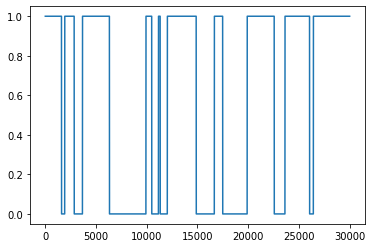

In [475]:
plt.plot(model2.sample(30000)[1])

In [123]:
58410

58410

In [126]:
58410/(len(genome)*2)

0.9767231865155012

In [510]:
genome[13450:13500]
# TTTTTAAA is a 'slippery sequence' and this results in a programmable -1 ribosomal frameshift
# this is why there is a frame shift at this position in ORF1ab. 
# The in-frame stop codon TAA can be programmatically skipped and the gene continues in a -1 shifted frame.

'GATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTT'

In [39]:
k = 9
buffer = genome[0:k]
kmers = {}
for x in genome[k:]:
    buffer = buffer[1:] + x
    if buffer in kmers:
        kmers[buffer] = kmers[buffer] + 1
    else:
        kmers[buffer] = 1

In [463]:
len(kmers)

26355

In [42]:
common = {k: v for  k, v in kmers.items() if kmers[k] > 3}
print(len(common))

59


In [43]:
common1 = {k:v for k,v in common.items() if (sum([1 if x == "A" or x == "T" else 0 for x in k]) > 5)}
common2 = {k:v for k,v in common.items() if (sum([1 if x == "A" or x == "T" else 0 for x in k]) <= 5)}
print(len(common1), len(common2))
print(common2)

41 18
{'CACCTTTTG': 5, 'TGCTGTTGT': 4, 'GCTGTTGTT': 4, 'CTTTTGGTG': 4, 'GAAGAAGCT': 4, 'TGGACAACA': 4, 'GGACAACAG': 4, 'GATGGTGTT': 5, 'ATGGTGTTG': 5, 'TTGCTGCTA': 4, 'TTGATGGTG': 4, 'CACAGACTT': 4, 'TGGTAATGC': 4, 'CTGTTGCTA': 4, 'GTTGTGATG': 4, 'TGTTGACAC': 4, 'GTTGATGGT': 4, 'TGATGGTGT': 4}


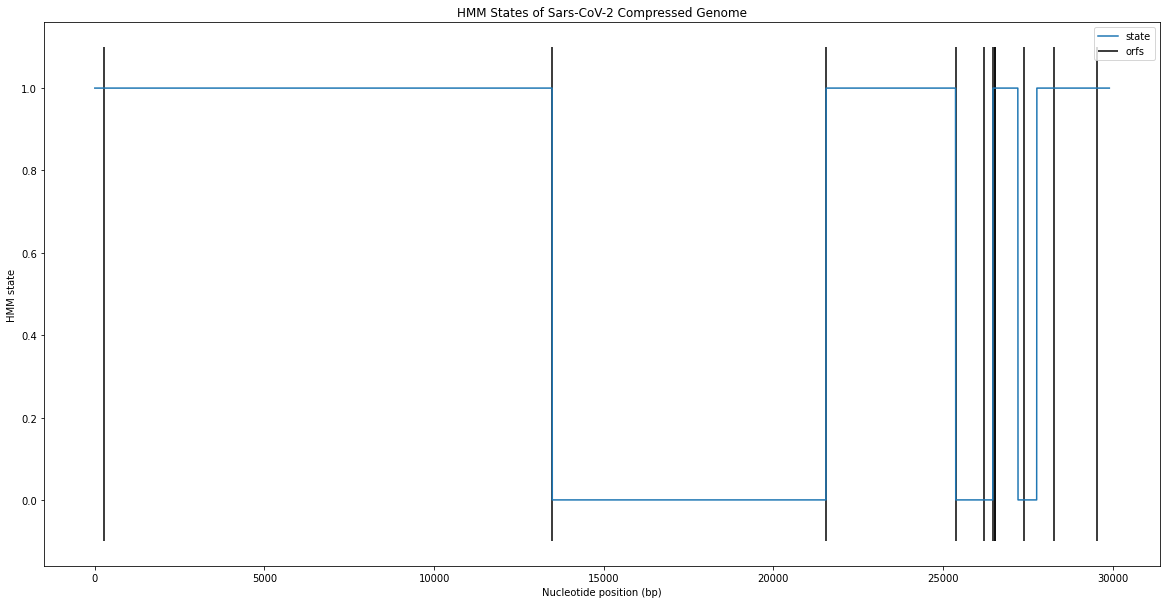

In [60]:
def is_a_kmer(kmer):
    return int(kmer in common1) -2*int(kmer in common2)

def contains_a_kmer(index):
    return any([int(genome[index - i:index - i + k] in common) for i in range(k)])

barcode = [is_a_kmer(x) for x in [genome[i:i+k] for i in range(0, len(genome) - k)]]
#barcode2 = [contains_a_kmer(x) for x in range(k, len(genome) - k)]

plt.figure(figsize= (20, 10))
plt.title("HMM States of Sars-CoV-2 Compressed Genome")
plt.xlabel("Nucleotide position (bp)")
plt.ylabel("HMM state")
#plt.legend(["hmm state", "orfs"])
#plt.plot(barcode)
plt.plot(np.linspace(1, len(genome), len(y[1])), y[1], label="state")

i = 1
#plt.xlim(13450, 13500)
plt.vlines((266, 13483,21555, 25392, 26220, 26472, 26523, 26523, 27387, 28274, 29533), ymin=-0.1, ymax=1.1, color="black", label="orfs")
plt.legend()
#print(sum(barcode))

In [583]:
9 * 2

18

In [530]:
9 * 59 * 4

2124

In [481]:
1689/30000

0.0563

In [ ]:
"start codon - ATG"
"stop codons - TAG, TAA, TGA"
"orfs - "
"ord1a 266-13483"
"orf1ab 266-21555"
"S - 25392-26220" 

In [725]:
align_distance('TTGCTGCTA', 'TGCTGCTAA')

(6, 'DRMMMMMMIR')

In [893]:
k = 12
buffer = genome[0:k]
kmers = {}
for x in genome[k:]:
    buffer = buffer[1:] + x
    if buffer in kmers:
        kmers[buffer] = kmers[buffer] + 1
    else:
        kmers[buffer] = 1

common = {k: v for  k, v in kmers.items() if kmers[k] > 1}
#ccommon = {k: v for k,v in kmers.items() if any(align_distance(k, c)[0] < 6 for c in common)}
print(len(common))
#print(len(ccommon))

110


In [894]:
#common = ccommon

In [895]:
T = len(common)
dists = np.zeros((T,T))
common_list = list(common)
for i in range(T):
    if i % 100 == 0:
        print(i)
    for j in range(T):
        dists[i,j] = float(align_distance(common_list[i], common_list[j], sub_cost=sub_matrix_2)[0])

0
100


In [896]:
dists

array([[ 0.,  6., 12., ..., 12., 12., 10.],
       [ 6.,  0.,  6., ..., 11., 12.,  9.],
       [12.,  6.,  0., ..., 12., 11.,  8.],
       ...,
       [12., 11., 12., ...,  0.,  6., 10.],
       [12., 12., 11., ...,  6.,  0., 12.],
       [10.,  9.,  8., ..., 10., 12.,  0.]])

In [897]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=55,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dists).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", random_state=55, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(dists, init=pos)

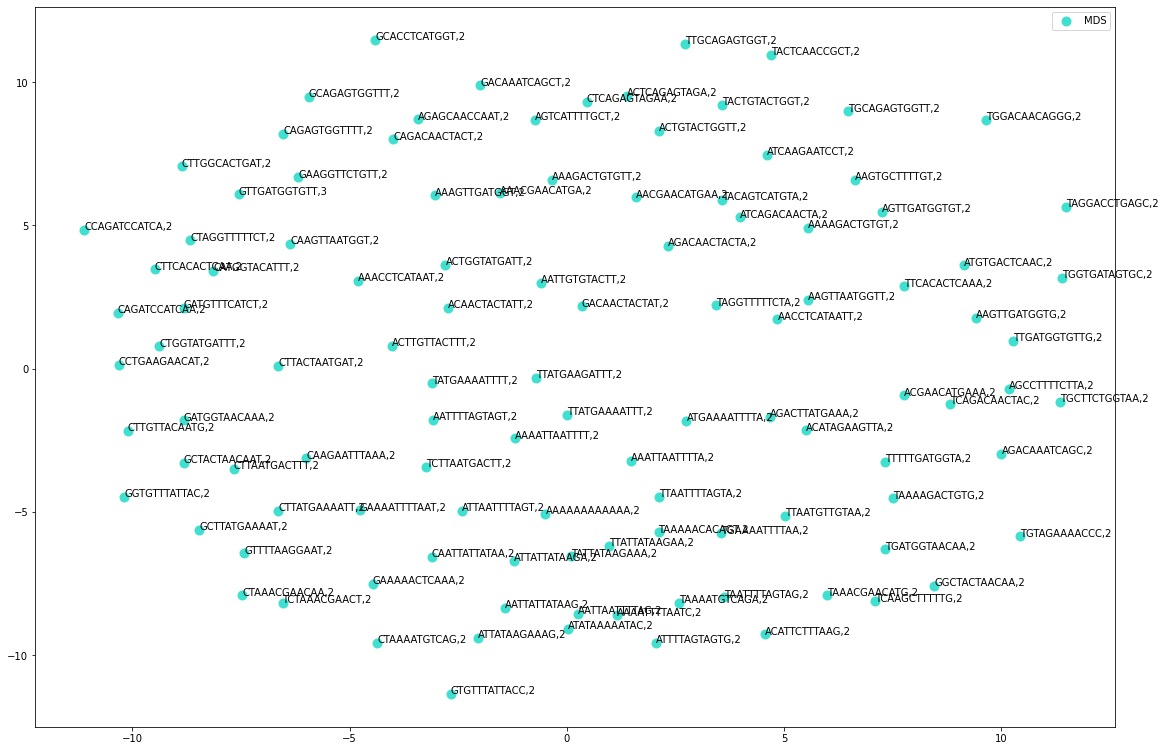

In [898]:
fig = plt.figure(1, figsize=(15, 10))
ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
#plt.scatter(npos[:, 0], npos[:, 1], color='darkorange', s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)

for i, txt in enumerate(common_list):
    ax.annotate(txt + "," + str(common[txt]), (pos[i,0], pos[i,1]))

In [899]:
512 == 2 ** 9

True

In [900]:
sum(contains_a_kmer(x) for x in range(k, len(genome) - k))

1505

In [901]:
11*2 - 9

13

In [903]:
1505 * (2 - (7/24))

2571.0416666666665

In [904]:
2600/60000

0.043333333333333335